## 1.Downloading stanford glove vector

In [1]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

--2021-12-14 05:09:57--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-12-14 05:09:57--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.08MB/s    in 4m 45s  

2021-12-14 05:14:43 (5.08 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]



In [2]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [3]:
!ls

glove.twitter.27B.100d.txt  glove.twitter.27B.25d.txt  glove.twitter.27B.zip
glove.twitter.27B.200d.txt  glove.twitter.27B.50d.txt  sample_data


## 2.Reading Data

In [4]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [6]:
data1 = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
data2 = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
data =  pd.concat([data1, data2])
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## 3.Preprocessing Text

In [7]:
def clean_text(text):
    text = text.lower()
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [8]:
>>> import nltk
>>> nltk.download('punkt')


>>> import nltk
>>> nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(lines):
    head_lines = list()
    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        words=" ".join(words)
        head_lines.append(words)
    return head_lines

In [10]:
import pandas as pd
from tqdm import tqdm
import re 
from sklearn.model_selection import train_test_split

In [11]:
X=data["headline"]
Y=data["is_sarcastic"]

In [12]:
X = CleanTokenize(X)

## 4.Train,Cv and Test

In [13]:
import pandas as pd
from tqdm import tqdm
import re 
from sklearn.model_selection import train_test_split

In [14]:
x_tr,x_test,y_tr,y_test=train_test_split(X,Y,test_size=0.30,random_state=42,stratify=Y)

x_train,x_cv,y_train,y_cv=train_test_split(x_tr,y_tr,test_size=0.30,random_state=42,stratify=y_tr)

In [15]:
print(len(x_train),len(x_cv),len(x_test))

27110 11619 16599


## 5.Deep learning Model
### 5.1 Tokenization

In [16]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import json

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
#tokenizer data
vocab_size=len(tokenizer.word_index)+1
print(vocab_size)

24440


In [19]:
max_len = 25

### 5.2. padding and text to sequence

In [20]:
train_sequences = tokenizer.texts_to_sequences(x_train)

train_padded = pad_sequences(
    train_sequences, maxlen=max_len, truncating="post", padding="post"
)

cv_sequences = tokenizer.texts_to_sequences(x_cv)
cv_padded = pad_sequences(
    cv_sequences, maxlen=max_len, padding="post", truncating="post"
)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(
    test_sequences, maxlen=max_len, padding="post", truncating="post"
)

### 5.3. Word Embedding

In [21]:
embedding_dict = dict()
embedding_dim = 100
with open("glove.twitter.27B.100d.txt", "r") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], "float32")
        embedding_dict[word] = vectors
f.close()

In [22]:
vocab_size = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

### 5.4. Training deep learning model

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM,GlobalMaxPool1D,Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [25]:
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=25,
                            trainable=False)

In [58]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model.add(LSTM(128, dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           2444000   
                                                                 
 lstm_17 (LSTM)              (None, 25, 64)            42240     
                                                                 
 lstm_18 (LSTM)              (None, 25, 128)           98816     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                       

In [59]:
history = model.fit(train_padded,y_train, batch_size=32, epochs=15, validation_data=(cv_padded, y_cv), verbose=1)

Epoch 1/15
848/848 [==============================] - 105s 118ms/step - loss: 0.5278 - acc: 0.7351 - val_loss: 0.4595 - val_acc: 0.7775
Epoch 2/15
848/848 [==============================] - 99s 117ms/step - loss: 0.4491 - acc: 0.7878 - val_loss: 0.4250 - val_acc: 0.7978
Epoch 3/15
848/848 [==============================] - 99s 117ms/step - loss: 0.4073 - acc: 0.8142 - val_loss: 0.4043 - val_acc: 0.8099
Epoch 4/15
848/848 [==============================] - 101s 119ms/step - loss: 0.3776 - acc: 0.8283 - val_loss: 0.3812 - val_acc: 0.8230
Epoch 5/15
848/848 [==============================] - 101s 119ms/step - loss: 0.3516 - acc: 0.8436 - val_loss: 0.3747 - val_acc: 0.8281
Epoch 6/15
848/848 [==============================] - 101s 119ms/step - loss: 0.3279 - acc: 0.8571 - val_loss: 0.3541 - val_acc: 0.8421
Epoch 7/15
848/848 [==============================] - 101s 119ms/step - loss: 0.3108 - acc: 0.8661 - val_loss: 0.3489 - val_acc: 0.8467
Epoch 8/15
848/848 [==============================

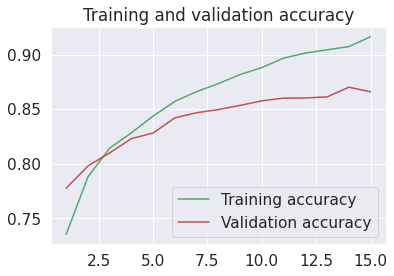

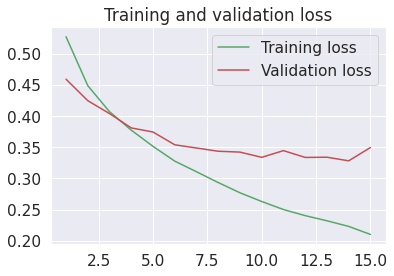

In [62]:
# Plot results
import numpy as np 
import pandas as pd
import os
import re
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 5.5. Testing Model

Accuracy on test set: 86.559%
F1-Score on test set: 0.841
-------------------- confusion matrix --------------------


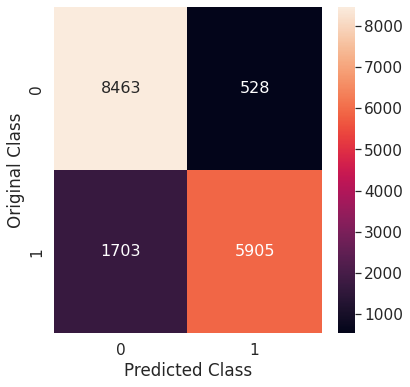

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

y_pred = model.predict(test_padded)
y_pred = np.round(y_pred).astype(int)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(6,6))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()